# Transfer learning for face analysis


**Package installations**

In [ ]:
import tensorflow
import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from keras_vggface.vggface import VGGFace


In [ ]:
# !pip install keras_applications 
# !pip install keras_vggface

In [ ]:
import keras_vggface
import keras_applications

## Data loading

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data = np.load("gdrive/MyDrive/cacd_vs_img_bgr_preprocessed.npz", allow_pickle=True)
data.files

['x_0', 'x_1', 'y', 'orig_ids']

In [ ]:
x_0 = data['x_0']
x_1 = data['x_1']
y = data['y']
orig_ids = data['orig_ids']

## Data Visualisation

In [ ]:
def to_rgb(img):
  return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

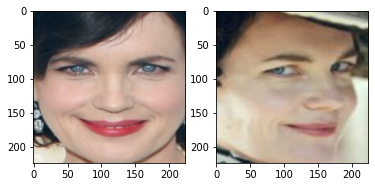

Y = 1


In [ ]:
# positive pair
plt.subplot(121)

img_float = x_0[100]
img_disp = (img_float - img_float.min()) / (img_float.max() - img_float.min())
plt.imshow(cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB))

plt.subplot(122)
img_float = x_1[100]
img_disp = (img_float - img_float.min()) / (img_float.max() - img_float.min())
plt.imshow(cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB))
plt.show()
print(f"Y = {y[100]}")

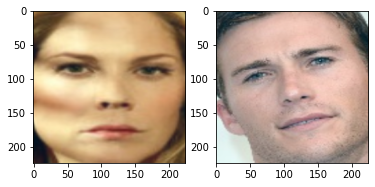

Y = 0


In [ ]:
# negative pair
plt.subplot(121)

img_float = x_0[200]
img_disp = (img_float - img_float.min()) / (img_float.max() - img_float.min())
plt.imshow(cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB))

plt.subplot(122)
img_float = x_1[200]
img_disp = (img_float - img_float.min()) / (img_float.max() - img_float.min())
plt.imshow(cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB))
plt.show()
print(f"Y = {y[200]}")

## Model building

In [ ]:
vggface = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')

94699520/94694792 [==============================] - 19s 0us/step


In [ ]:
Y_pred_0 = vggface.predict(x_0[:400])
Y_pred_1 = vggface.predict(x_1[:400])

In [ ]:
# euclidean distance

dist = [np.linalg.norm(Y_pred_1[i]-Y_pred_0[i]) for i in range(400)]

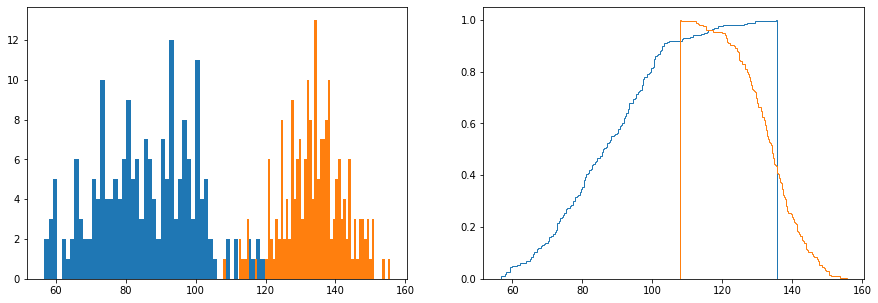

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
# positive matches
plt.hist(dist[:200], bins=64)
# negative matches
plt.hist(dist[200:],bins=64)

plt.subplot(122)
# positive matches
plt.hist(dist[:200], bins=200, density=True, histtype='step', cumulative=1)
# negative matches
plt.hist(dist[200:], bins=200, density=True, histtype='step', cumulative=-1)
plt.show()

In [ ]:
dist = 1 - (dist - min(dist))/(max(dist) - min(dist))

area under the curve = 0.9920249999999999


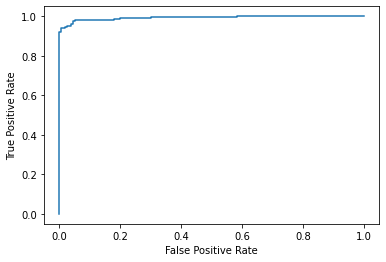

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y[:400], dist)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

print(f"area under the curve = {roc_auc_score(y[:400], dist)}")

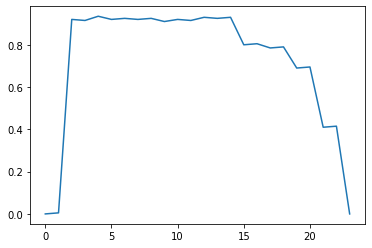

In [ ]:
plt.plot(tpr-fpr)

4 0.005 0.94 0.4440179


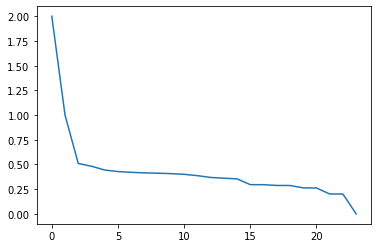

In [ ]:
x = np.argmax(tpr-fpr)
print(x, fpr[x], tpr[x], thresholds[x])
plt.plot(thresholds)

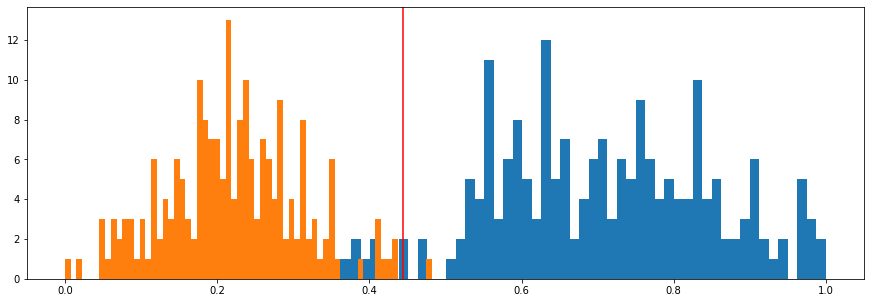

In [ ]:
plt.figure(figsize=(15, 5))

# positive matches
plt.hist(dist[:200], bins=64)
# negative matches
plt.hist(dist[200:],bins=64)

plt.axvline(x=thresholds[x], c='r')

plt.show()

In [ ]:
dist[dist < thresholds[x]] = 0
dist[dist >= thresholds[x]] = 1


In [ ]:
sklearn.metrics.accuracy_score(y[:400], dist)

0.9675

In [ ]:
neg_histogram, edges = np.histogram(dist[200:], bins=200, density=False)

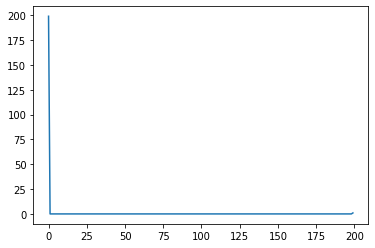

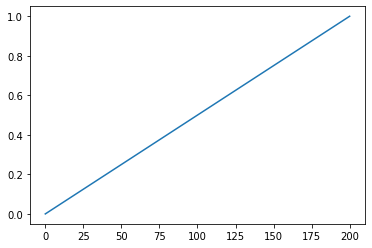

In [ ]:
plt.plot(neg_histogram)
plt.show()
plt.plot(edges)

**prediction on other values**

In [ ]:
x_0[400:800].shape

(400, 224, 224, 3)

In [ ]:
Y_test_0 = vggface.predict(x_0[400:800])

In [ ]:
Y_test_1 = vggface.predict(x_1[400:800])

In [ ]:
dist_test = [np.linalg.norm(Y_test_0[i]-Y_test_1[i]) for i in range(400)]
dist_test = 1 - (dist_test - min(dist_test))/(max(dist_test) - min(dist_test) + 0.0001)

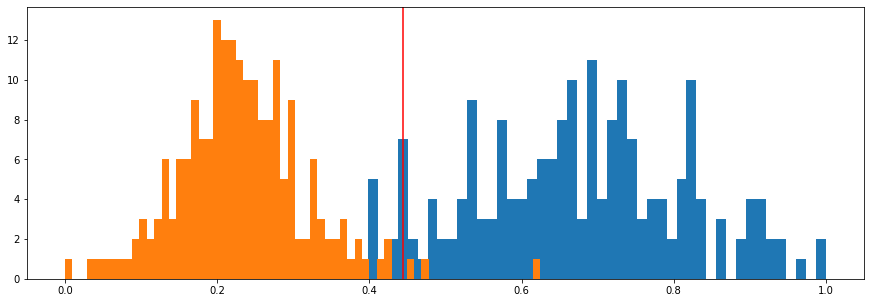

In [ ]:
plt.figure(figsize=(15, 5))

# positive matches
plt.hist(dist_test[:200], bins=64)
# negative matches
plt.hist(dist_test[200:],bins=64)

plt.axvline(x=thresholds[x], c='r')

plt.show()

In [ ]:
dist_test[dist_test < thresholds[x]] = 0
dist_test[dist_test >= thresholds[x]] = 1

In [ ]:
sklearn.metrics.accuracy_score(y[400:800], dist_test)

0.945

## Siamese architecture

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(
#     rescale=1./255.,
#     samplewise_center=True,
#     horizontal_flip=True,
#     validation_split=0.3
# )

# train_generator = datagen.flow(
#     [x_0, x_1],
#     y,
#     batch_size=32,
#     subset="training",
#     seed=42,
#     shuffle=True)

# val_generator = datagen.flow(
#     [x_0, x_1],
#     y,
#     batch_size=32,
#     subset="validation",
#     seed=42,
#     shuffle=True)

In [ ]:
from keras.utils import Sequence

class Mygenerator(Sequence):
    def __init__(self, x1, x2, y, batch_size):
        self.x1, self.x2, self.y = x1, x2, y
        self.batch_size = batch_size
        self.indices = np.arange(self.x1.shape[0])

    def __len__(self):
        return len(self.x1) // self.batch_size

    def __getitem__(self, idx):
        x1 = self.x1[idx * self.batch_size:(idx + 1) * self.batch_size]
        x2 = self.x2[idx * self.batch_size:(idx + 1) * self.batch_size]
        y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return [np.array(x1), np.array(x2)], np.array(y)
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)


In [ ]:
del(data)

In [ ]:
from sklearn.model_selection import train_test_split

X0_train, X0_test, X1_train, X1_test, y_train, y_test = train_test_split(x_0, x_1, y, test_size=0.33, random_state=42)

In [ ]:
# pour recup de la RAM
del(x_1)
del(y)

In [ ]:
X1_train = (X1_train - X1_train.mean())/X1_train.std()
X0_train = (X0_train - X0_train.mean())/X0_train.std()

X1_test = (X1_test - X1_test.mean())/X1_test.std()
X0_test = (X0_test - X0_test.mean())/X0_test.std()

In [ ]:
train_generator = Mygenerator(X0_train, X1_train, y_train, 32)
val_generator = Mygenerator(X0_test, X1_test, y_test, 32)

In [ ]:
np.unique(im)

array([-2.7475138, -2.7296512, -2.7263117, ...,  2.4969168,  2.5042806,
        2.5147793], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1

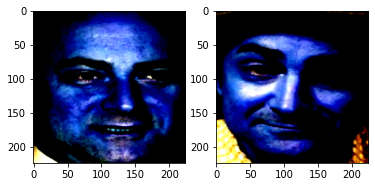

In [ ]:
im, lab = val_generator.__getitem__(9)

img_disp = im[1][10]
plt.subplot(121)
plt.imshow(im[0][10])
plt.subplot(122)
plt.imshow(img_disp )
lab[10]

In [ ]:
from keras import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Input, Flatten, Lambda, merge
from sklearn.metrics.pairwise import manhattan_distances
import tensorflow as tf
import keras.backend as K


In [ ]:
def siamese_model(vggface, input_shape):
  input_left = Input(input_shape)
  input_right = Input(input_shape)

  model_1 = vggface(input_left, training=False)
  model_2 = vggface(input_right, training=False)

  # model_1 = Flatten(name='flatten')(model_1)
  # model_2 = Flatten(name='flatten')(model_2)


  # dist = manhattan_distances(model_1, model_2)
  # dist = K.sum(K.abs(model_2 - model_1))
  
  # model_1 = Dense(4096, activation='sigmoid')(model_1)
  # model_2 = Dense(4096, activation='sigmoid')(model_2)

  L1_layer = Lambda(lambda models: K.abs(models[0] - models[1]))

  # Add the distance function to the network
  dist_layer = L1_layer([model_1, model_2])
  out = Dense(128, activation='sigmoid')(dist_layer)
  out = Dense(1, activation='sigmoid')(out)

  return Model(inputs=[input_left, input_right], outputs=out)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_filepath = 'siamese.h5'

callbacks = [
             ModelCheckpoint(
                 filepath=checkpoint_filepath,
                 save_weights_only=True,
                 monitor='val_accuracy',
                 mode='max',
                 verbose=1,
                 save_best_only=True
                 ),
             #EarlyStopping(
             #    monitor='val_accuracy',
             #    min_delta=0,
             #    patience=3,
             #    verbose=1,
             #    restore_best_weights=True
             #    ),
             ]

In [ ]:
from keras.optimizers import Adam

input_shape = x_0[0, ...].shape
vggface = VGGFace(model='vgg16', include_top=False, input_shape=(224, 224, 3), pooling='avg')
vggface.trainable = False
# for layer in vggface.layers[:]:
#     layer.trainable = False

model = siamese_model(vggface, input_shape)

print(model.summary())

optimizer = Adam(lr=0.0001, decay=0.001/20)
# optimizer = Adam(lr=0.0001, decay=2.5e-4)

model.compile(loss="binary_crossentropy",
              optimizer= optimizer,
              metrics=['accuracy'])

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vggface_vgg16 (Functional)      (None, 512)          14714688    input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512)          0           vggface_vgg16[0][0]   

In [ ]:
 EPOCHS = 20
 BATCH_SIZE = 32

train_generator = Mygenerator(X0_train, X1_train, y_train, BATCH_SIZE)
val_generator = Mygenerator(X0_test, X1_test, y_test, BATCH_SIZE)

 siamese_history = model.fit(
     train_generator,
     validation_data=val_generator,
     epochs=EPOCHS,
     callbacks=callbacks,
 )

Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 0.6831 - accuracy: 0.5023
Epoch 00001: val_accuracy improved from -inf to 0.49543, saving model to siamese.h5
83/83 [==============================] - 33s 397ms/step - loss: 0.6831 - accuracy: 0.5023 - val_loss: 0.6703 - val_accuracy: 0.4954
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 0.6577 - accuracy: 0.5542
Epoch 00002: val_accuracy improved from 0.49543 to 0.55259, saving model to siamese.h5
83/83 [==============================] - 32s 385ms/step - loss: 0.6577 - accuracy: 0.5542 - val_loss: 0.6460 - val_accuracy: 0.5526
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 0.6348 - accuracy: 0.6905
Epoch 00003: val_accuracy improved from 0.55259 to 0.73628, saving model to siamese.h5
83/83 [==============================] - 31s 379ms/step - loss: 0.6348 - accuracy: 0.6905 - val_loss: 0.6230 - val_accuracy: 0.7363
Epoch 4/20
83/83 [==============================] - ETA: 0s - lo

In [ ]:
siamese_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

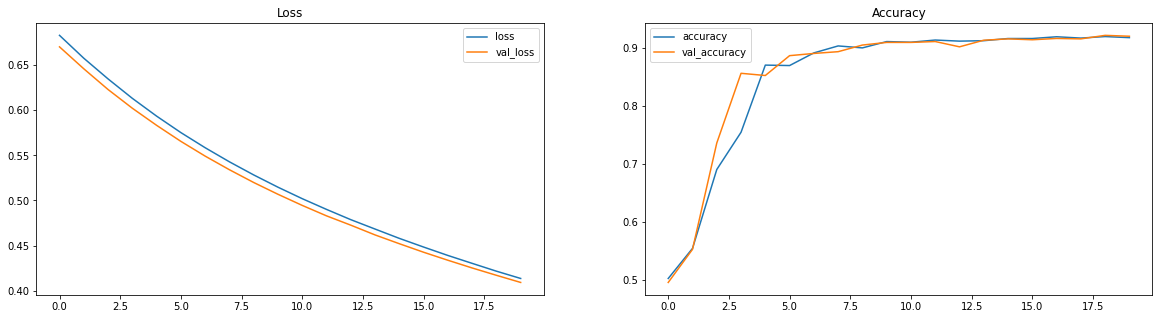

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(siamese_history.history['loss'], label='loss')
plt.plot(siamese_history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Loss")
plt.subplot(122)
plt.plot(siamese_history.history['accuracy'], label='accuracy')
plt.plot(siamese_history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title("Accuracy")
plt.show()

In [ ]:
K.clear_session()